# Training Time Series Classifiers Based on Deep Learning
<strong>Abraham C. Montes</strong> <br>
<a href="https://www.linkedin.com/in/abraham-c-montes-6661a841/">LinkedIn</a>|<a href="https://www.abraham-montes.com/">Personal Site</a><br>
The University of Texas at Austin | <a href="https://drilling.utexas.edu/">RAPID research consortium</a>


<strong> Description: </strong> <br>
The objective of this notebook is to train time-series classifiers based on deep learning for rig/well activity identification. The models implemented here are of two types: An LSTM recurrent neural network and a transformer for time series classification. Both models are constructed using the PyTorch library and leverage GPU hardware for faster, more efficient training.

In [1]:
import logging

class LoggerDev:

    def __init__( self,verbosity=2 ):
      for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
      logging.basicConfig(   format='[%(levelname)s]......... %(message)s', level=logging.DEBUG   )
      self.verbosity      =   verbosity

    def setVerbosity( self,verbosity ):
        self.verbosity      = verbosity
        logging.info( f"Verbosity has been set to {verbosity}" )

    def dbgMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>1):
            logging.debug(  msg  )

    def infoMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>1):
            logging.info(  msg  )

    def warningMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>0):
            logging.warning(  msg  )

    def errorMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>-1):
            logging.error(  msg  )



In [2]:
class Nomenclature:

    DATE_MNEMONIC           = "Date"
    BIT_DEPTH_MNEMO         = "Bit Depth [ft]"
    DEPTH_MNEMONIC          = "Measured Depth [ft]"
    DEPTH_MNEMONIC_METRIC   = "Measured Depth [m]"
    TORTUOSITY_MNEMO        = "Tortuosity Idx"
    INCLINATION_MNEMO       = 'Inclination [°]'
    AZIMUTH_MNEMO           = 'Azimuth [°]'
    DLS_MNEMO               = 'DLS [°/100 ft]'
    GAMMA_RAY_LOG_MNEMO     = "Gamma Ray [API]"
    ROP_MNEMO               = "ROP [fph]"
    TORQUE_MNEMO            = "Torque [lb-ft]"
    WOB_MNEMO               = "Weight on Bit [klb]"
    STANDPIPE_PRESSURE_MNEMO="Standpipe Pressure [psi]"
    RPM_MNEMO               = "Surface Rotation [rpm]"
    HOOK_LOAD_MNEMO         = "Hook Load [klb]"
    HOLE_DEPTH_MNEMO        = "Hole Depth [ft]"
    FLOW_IN_MNEMO           = "Flow In [gpm]"
    BLOCK_POSITION_MNEMO    = "Block Position [ft]"
    RIG_STATE_MNEMO         = "Rig State"
    RIG_ACTIVITY_MNEMO      = "Activity"
    SECTION_PHASE_MNEMO     = "Section Operation Phase"
    TORTUOSITY_BIT_MNEMO    = 'Tortuosity Idx at Bit'
    FLEX_RIGIDITY_BIT_MNEMO = 'Flex Rigidity Difference at Bit'
    BLOCK_WEIGHT_MNEMO      = 'Block Weight [klb]'
    TRIP_OUT_MNEMO          = "Trip Out"
    DRILLING_MNEMO          = "Drilling"
    CIRCULATION_MNEMO       = "Circulation"
    BLOCK_WEIGHT_DELTA_MNEMO= "delta"
    BLOCK_WEIGHT_DELTA_DATES_MNEMO="dates"
    BLOCK_POSITION_TREND_MNEMO='Block Position Trend'
    FLOW_RATE_VARIABILITY_MNEMO='Flow Rate Variability'
    FLOW_RATE_MEAN_MNEMO        ='Flow Rate Mean'
    RPM_MEAN_MNEMO          = 'RPM Mean'
    HOOK_LOAD_MEAN_MNEMO    = 'Hook Load Mean'
    HOOK_LOAD_VARIABILITY_MNEMO='Hook Load Variability'
    EFF_HOOK_LOAD_MNEMO     = 'Effective Hook Load [klb]'
    ROP_MEAN_MNEMO          = 'ROP Mean'
    BACKREAMING_MNEMO       = 117
    TRIP_OUT_ELEV_MNEMO     = 112
    PUMPING_OUT_MNEMO       = 115
    REAMING_MNEMO           = 116
    DRILLING_ROT_MNEMO      = 119
    CONNECTION_MNEMO        = 118
    TRANSFORMER_MODEL_MNEMO = "transformer"
    LSTM_MODEL_MNEMO        = "lstm"
    GOAL_RIG_STATES         = [111,112,114,115,116,117,118,119,120,121]
    DICT_RIG_STATES         = {
                                    111:"Tripping in on elevators",
                                    112:"Tripping out on elevators",
                                    114:"Washing down",
                                    115:"Pumping out",
                                    116:"Reaming",
                                    117:"Backreaming",
                                    118:"Connection/Other surface operations",
                                    119:"Drilling (with surface rotation)",
                                    120:"Drilling (sliding)",
                                    121:"Circulating"
                                }
    CONVERTION_HASH_TABLE   = {
            "TIME":                             DATE_MNEMONIC,
            "DBTM":                             BIT_DEPTH_MNEMO,
            "BPOS":                             BLOCK_POSITION_MNEMO,
            "MFIA":                             FLOW_IN_MNEMO,
            "DMEA":                             HOLE_DEPTH_MNEMO,
            "HKLA":                             HOOK_LOAD_MNEMO,
            "RPMA":                             RPM_MNEMO,
            "SPPA":                             STANDPIPE_PRESSURE_MNEMO,
            "WOBA":                             WOB_MNEMO,
            "TQA":                              TORQUE_MNEMO,
            # "ROPA__":                           ROP_MNEMO,
            #Note (10/21/24): For some unknown issue within Shell's system, the 'ROPA__' channel
            # is sometimes unavailable (full with NaNs). An alternative is the one below.
            "ROPA__SHELL_CALCULATION_INPUT_TIME":ROP_MNEMO,
            "MD":                               DEPTH_MNEMONIC,
            "INCLINATION":                      INCLINATION_MNEMO,
            "AZIMUTH":                          AZIMUTH_MNEMO,
            "DLS":                              DLS_MNEMO,
            "DEPTH":                            DEPTH_MNEMONIC,
            "SGRC":                             GAMMA_RAY_LOG_MNEMO
        }



In [3]:
import torch
import torch.nn as nn
import numpy as np

class TimeSeriesTransformer( nn.Module ):

    def __init__( self, nInputs,dModel,nHead,nLayers,dimFeedForward,nOutput,dropoutRate=0.1 ):
        super( TimeSeriesTransformer,self ).__init__( )
        self.D                  = nInputs
        self.dModel             = dModel
        self.inputProjection    = nn.Linear(  nInputs, dModel  )
        self.posEncoding        = nn.Parameter( self._generatePosEncoding( dModel, maxLength=500 ), requires_grad=False )
        encoderLayer            = nn.TransformerEncoderLayer( d_model=dModel, nhead=nHead, dim_feedforward=dimFeedForward, dropout=dropoutRate )
        self.transformerEncoder = nn.TransformerEncoder(encoderLayer, num_layers=nLayers)
        self.fc                 = nn.Linear( dModel, nOutput  )
        self.softmax            = nn.Softmax( dim=1 )

    def _generatePosEncoding(  self, dModel, maxLength  ):
        position                = torch.arange(  0, maxLength  ).unsqueeze(1)
        divTerm                 = torch.exp(torch.arange(  0, dModel, 2) * -(np.log(10000.0) / dModel)  )
        posEncoding             = torch.zeros(  maxLength, dModel  )
        posEncoding[ :, 0::2 ]    = torch.sin(  position * divTerm  )
        posEncoding[ :, 1::2 ]    = torch.cos(  position * divTerm  )
        return posEncoding.unsqueeze( 0 )

    def forward( self, x ):
        x                       = self.inputProjection( x )
        x                       = x + self.posEncoding[ :, :x.size(1), : ]
        x                       = x.permute(1, 0, 2)
        x                       = self.transformerEncoder( x )
        x                       = x[ -1, :, : ]
        output                  = self.fc( x )
        return self.softmax( output )

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy as sp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import sys
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import joblib

class Trainer:

    FDICT_PLOTS                 = {'family':'Arial','size':8}
    LOWER_LIM_HKL_FOR_BLOCK_WEIGHT      = 200
    UPPER_LIM_HKL_FOR_BLOCK_WEIGHT      = 1000

    def __init__( self ):
        self.logger             = LoggerDev(  )
        self.dataSets           = [  ]
        self.concatDataset      = [  ]
        self.blockWeights       = [  ]
        self.nom                = Nomenclature(  )
        self.labelPreds         = {  }
        self.scaler             = StandardScaler( )
        self.slidingWindow      = None

    def setSlidingWindow( self,slidingWindow ):
        self.slidingWindow      = slidingWindow

    def loadData( self,pathFolder,blockWeights={  },nBinsBWInference=100,dropNaNs=True ):
        for file in os.listdir( pathFolder ):
            if file==".ipynb_checkpoints":  continue
            df                                  = pd.read_csv( pathFolder+"/"+file,parse_dates=[ self.nom.DATE_MNEMONIC ],na_values=[-999.25] )
            if dropNaNs:                        df                                  = df.dropna( axis=0 )
            if file[ :-4 ] in list( blockWeights.keys(  ) ):
                bW                              =   blockWeights[ file[ :-4 ] ]
            else:
                bW                              =   self._getBlockWeight( df,nbins=nBinsBWInference )
                self.logger.warningMsg( f"The block weight for the {file[ :-4 ]} well was not provided. Therefore, it has been inferred. Its value is: {bW:.1f}" )
            df[ self.nom.BLOCK_WEIGHT_MNEMO ]   = bW
            self.dataSets.append( df )
            self.blockWeights.append( bW )
            self.logger.infoMsg( f"Block weight for {file} has been set on: {bW:.1f} klb." )
        self.logger.infoMsg( f"Data has been loaded correctly to the trainer. In total, {len( self.dataSets )} dataframes have been loaded." )

    def _loadCheckPoint( self, currentCheckPointPath, model, optimizer ):
        checkpoint                              = torch.load(  currentCheckPointPath, weights_only=False  )
        model.load_state_dict(  checkpoint['model_state_dict']  )
        optimizer.load_state_dict(  checkpoint['optimizer_state_dict']  )
        return model, optimizer

    def trainModel(  self, modelType, batchSize=32, nEpochs=200, learningRate=0.0001, currentCheckPointPath=None,
                    saveModel=True, savePath="model_transformer.pth", saveScaler=True, scalerPath="scaler_transformer.pkl",
                     stratifyData=True,fitScaler=True, **kwargs  ):
        if len( self.dataSets )==0:
            self.logger.errorMsg( "No data has been loaded to the trainer. Use the loadData( ) function before training a model." )
            sys.exit( 1 );
        model, optimizer        = self._createModel( modelType,learningRate, **kwargs )
        self.logger.infoMsg( f"The {modelType} model has been created." )
        currEpoch               = 0
        trainLosses             = np.zeros( nEpochs )
        if 'slidingWindow' not in kwargs:
            self.slidingWindow  = 5
            self.logger.warningMsg( f"The size of the sliding window has not been specified. By default, it has been set on {self.slidingWindow}." )
        else: self.slidingWindow= kwargs['slidingWindow']
        if currentCheckPointPath is not None:
            model, optimizer    = self._loadCheckPoint( currentCheckPointPath, model, optimizer )
            self.logger.infoMsg( "Checkpoint loaded successfully. Resuming training..." )
        else:                   self.logger.infoMsg( "Starting training..." )
        device                  = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        typeDevice              = "GPU" if torch.cuda.is_available( ) else "CPU"
        self.logger.infoMsg(  f"Working on: {typeDevice}, model {torch.cuda.get_device_name(0)}"  )
        self.logger.infoMsg( "Extracting features for dataset No. 1." )
        X_train, y_train        = self.extractFeatures( self.dataSets[ 0 ],self.blockWeights[ 0 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
        if len( self.dataSets )>1:
            for k,ds in enumerate( self.dataSets[1:] ):
                self.logger.infoMsg( f"Extracting features for dataset No. {k+2}." )
                X_train_temp, y_train_temp  = self.extractFeatures( ds,self.blockWeights[ k+1 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
                X_train         = np.concatenate( [X_train,X_train_temp],axis=0 )
                y_train         = np.concatenate( [y_train,y_train_temp] )
        self.logger.infoMsg( f"The training dataset has the following shape: {X_train.shape[0]} X {X_train.shape[1]}. The response: {y_train.shape}" )
        X_train                 = self.scaler.transform( X_train )
        X_train, y_train        = self.wrapTensor( X_train,y_train,slidingWindow=self.slidingWindow )
        nNans                   = np.isnan( X_train ).sum(  )
        if nNans>0:             self.logger.warningMsg( f"There are {nNans} NaNs in the training dataset. Consider trimming NaNs before training." )
        X_train, y_train        = self._stratifyData( X_train, y_train,stratify=stratifyData )
        X_train                 = torch.from_numpy( X_train.astype(np.float32) ).to( device )
        y_train                 = torch.from_numpy( y_train.astype(np.float32) )
        y_train                 = torch.argmax( y_train, dim=1 ).to( device )
        self.logger.infoMsg( f"Size of the training data: {(X_train.numel(  ) * X_train.element_size(  ))/1E9:.2f} GB for the input matrix and {(y_train.numel(  ) * y_train.element_size(  ))/1E9:.2f} GB for the response variable." )
        if saveScaler:
            joblib.dump( self.scaler, scalerPath )
            self.logger.infoMsg( f"Successfully saved scaler: {scalerPath}" )
        criterion               = nn.CrossEntropyLoss(  )
        dataset                 = TensorDataset( X_train, y_train )
        dataLoader              = DataLoader( dataset, batch_size=batchSize, shuffle=True )
        self.logger.infoMsg( "Data loaded to the torch DataLoader object." )
        for epoch in range( nEpochs ):
            if epoch==0: self.logger.infoMsg( f"Initiating forward pass (epoch {epoch})." )
            model.train(  )
            runningLoss         = 0.0
            correctPreds        = 0
            totalPreds          = 0
            for batchNo, ( inputs, labels ) in enumerate( dataLoader ):
                if batchNo%150==0:self.logger.infoMsg( f'[LOADER>>>]..... Processing batch No. {batchNo}.')
                optimizer.zero_grad(  )
                outputs         = model( inputs )
                loss            = criterion( outputs, labels )
                loss.backward(  )
                optimizer.step(  )
                runningLoss     += loss.item(  )
                _, predicted    = torch.max( outputs, 1 )
                correctPreds    += ( predicted == labels ).sum(  ).item(  )
                totalPreds      += labels.size( 0 )
            epochLoss               = runningLoss / len(  dataLoader  )
            trainLosses[ epoch ] = epochLoss
            self.logger.infoMsg( f'[TRAINING MSG>>>]..... Epoch {epoch+1}/{nEpochs}, Train Loss: {loss.item(  ):.4f}')
            self._saveCheckpoint( model,optimizer,epoch,trainLosses[-1],modelType,codeName=f"_transformer_checkpoint.chpt" )
            self.logger.infoMsg( f"Successfully saved checkpoint: {modelType}.chpt" )
        if saveModel:
            torch.save(  model.state_dict(  ), savePath  )
            self.logger.infoMsg( f"Successfully saved {modelType} model: {savePath}" )
        return trainLosses, model
    
    def _stratifyData( self,X,y,stratify,nUndersamplingRounds=2 ):
        if not stratify:    return X,y
        yComp                   = np.argmax( y,axis=1 )
        countDict                   = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
        self.logger.infoMsg( f"Before undersampling, the counts per class are: {countDict}." )
        newX,newY               = ( X,y )
        newX,newY,countDict     = self._undersampling( newX,newY )
        self.logger.infoMsg( f"After undersampling, the counts per class are: {countDict}." )
        return newX,newY    
    
    def _undersampling( self,newX,newY,nTimes=2 ):
        buffX,buffY             = ( newX,newY )
        for i in range( nTimes ):
            yComp                   = np.argmax( buffY,axis=1 )
            countDict               = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
            classRef                = sorted( countDict,key=countDict.get,reverse=True )[i]
            classRefNext            = sorted( countDict,key=countDict.get,reverse=True )[i+1]
            diff                    = countDict[classRef] - countDict[classRefNext]
            rdSetDelete             = np.array( [ ] )
            for jClass in sorted( countDict,key=countDict.get,reverse=True )[0:i+1]:
                indices             = np.argwhere( yComp==jClass ).reshape( -1, )
                selection           = np.random.choice( indices, size=diff, replace=False )
                rdSetDelete         = np.concatenate( [ rdSetDelete,selection ] )
            allIdxs                 = np.setdiff1d( np.arange( buffX.shape[0] ), rdSetDelete ).astype( int )
            buffX                    = buffX[ allIdxs ]
            buffY                    = buffY[ allIdxs ]
        yComp                       = np.argmax( buffY,axis=1 )
        countDict                   = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
        return buffX,buffY,countDict

    def wrapTensor( self,X,y,slidingWindow ):
        XF                      = [ ]
        yF                      = [ ]
        for t in range( X.shape[ 0 ]-slidingWindow ):
            x                   = X[ t:t+slidingWindow,: ]
            XF.append( x )
            ny                  = y[ t+slidingWindow-1,: ]
            yF.append( ny )
        XF                      = np.array( XF ).reshape( -1,slidingWindow,X.shape[1] )
        yF                      = np.array( yF ).reshape( -1,y.shape[1] )
        # if modelType=="lstm":
        #     y_train                 = torch.from_numpy(yF.astype(np.float32)).to( device )
        # else:
        #     y_train                 = torch.from_numpy(yF.astype(np.float32))
        #     y_train                 = torch.argmax( y_train, dim=1 ).to( device )
        return XF.astype(np.float32),yF.astype(np.float32)

    def _getBlockWeight( self,dataSet,nbins=100 ):
        df                      = dataSet.copy( deep=True )
        df['Hook Load [klb]']   = np.where( (df[ self.nom.HOOK_LOAD_MNEMO ]<0) | (df[ self.nom.HOOK_LOAD_MNEMO ]>self.UPPER_LIM_HKL_FOR_BLOCK_WEIGHT), 0, df[ self.nom.HOOK_LOAD_MNEMO ])
        b                       = np.flip( np.argsort( np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[0] ) )
        c                       = np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1][b][  np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1][b]<self.LOWER_LIM_HKL_FOR_BLOCK_WEIGHT  ]
        delta                   = ( np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1].max(  ) - np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1].min(  ) )/(  2*nbins  )
        inferredBW              = c[0]+delta
        return inferredBW

    def extractFeatures( self, df, blockWeight, modelType,slidingWindow=5,fitScaler=False ):
        df[self.nom.EFF_HOOK_LOAD_MNEMO]            = np.where(df[self.nom.HOOK_LOAD_MNEMO]>0,df[self.nom.HOOK_LOAD_MNEMO]-df[self.nom.BLOCK_WEIGHT_MNEMO],df[self.nom.HOOK_LOAD_MNEMO])
        df[self.nom.BLOCK_POSITION_TREND_MNEMO]     = df[self.nom.BLOCK_POSITION_MNEMO].rolling(window=slidingWindow).apply(self._trend,raw=True,engine='cython')
        df[self.nom.FLOW_RATE_VARIABILITY_MNEMO]    = df[self.nom.FLOW_IN_MNEMO].rolling(window=slidingWindow).std(  )
        df[self.nom.FLOW_RATE_MEAN_MNEMO]           = df[self.nom.FLOW_IN_MNEMO].rolling(window=slidingWindow).mean(  )
        df[self.nom.RPM_MEAN_MNEMO]                 = df[self.nom.RPM_MNEMO].rolling(window=slidingWindow).mean(  )
        df[self.nom.HOOK_LOAD_MEAN_MNEMO]           = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=slidingWindow).mean(  )
        df[self.nom.HOOK_LOAD_VARIABILITY_MNEMO]    = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=slidingWindow).std(  )
        df[self.nom.ROP_MEAN_MNEMO]                 = df[self.nom.ROP_MNEMO].rolling(window=slidingWindow).mean(  )
        dfTraining                                  = df[[self.nom.BLOCK_POSITION_TREND_MNEMO,
                                                            self.nom.FLOW_RATE_VARIABILITY_MNEMO,
                                                            self.nom.FLOW_RATE_MEAN_MNEMO,
                                                            self.nom.RPM_MEAN_MNEMO,
                                                            self.nom.HOOK_LOAD_MEAN_MNEMO,
                                                            self.nom.ROP_MEAN_MNEMO,
                                                            self.nom.HOOK_LOAD_VARIABILITY_MNEMO,
                                                            self.nom.RIG_STATE_MNEMO]]
        dfTraining                                  = dfTraining.dropna( axis=0 )
        X                       = dfTraining.iloc[:,:-1].values
        y                       = dfTraining[self.nom.RIG_STATE_MNEMO].values
        y                       = pd.get_dummies( y )
        y                       = y.reindex( columns=self.nom.GOAL_RIG_STATES,fill_value=False )
        y                       = y.values        
        self.scaler.partial_fit( X )
        return X, y

    def plotLosses( self, trainingLoss, testLoss, outPath="loss_curve.png" ):
        fig,ax                    = plt.subplots( figsize=(6.83,3.33) )
        ax.plot( np.arange( len(trainingLoss) ), trainingLoss, lw=1.5, color='teal',label="Training Loss" )
        if not testLoss is None: ax.plot( np.arange( len(testLoss) ), testLoss, lw=1.5, color='red',ls='--',label="Test Loss" )
        ax.set_xlabel( 'Epoch', fontdict={ **self.FDICT_PLOTS,'weight':'bold'} )
        ax.set_ylabel( 'Loss (Cross Entropy)', fontdict={ **self.FDICT_PLOTS,'weight':'bold'} )
        ax.set_xticklabels( ax.get_xticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.set_yticklabels( ax.get_yticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.legend(  )
        plt.tight_layout(  )
        fig.savefig( outPath,dpi=600 )

    def _plotFancyContingencyTable(  self, confMatrix, classNames,outPath="contingency_table.png"  ):
        fig, ax                 = plt.subplots(  figsize=(  6.83, 4  ))
        buff                    = sb.heatmap(  confMatrix, annot=True, fmt="d", cmap="Blues",
                        xticklabels=classNames, yticklabels=classNames, ax=ax, annot_kws={ **self.FDICT_PLOTS }  )
        ax.set_xlabel(  "Predicted Labels",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_ylabel(  "True Labels",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_title(  "Confusion Matrix",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_xticklabels( ax.get_xticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.set_yticklabels( ax.get_yticklabels( ), fontdict=self.FDICT_PLOTS )
        plt.tight_layout(  )
        fig.savefig( outPath,dpi=600 )

    def _saveCheckpoint( self,model, optimizer, epoch, loss, modelType, path='checkpoint.pth',codeName="_" ):
        newPath    = f"{modelType}{codeName}_chk"
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(  ),
            'optimizer_state_dict': optimizer.state_dict(  ),
            'loss': loss
        }
        torch.save(  checkpoint, newPath  )
        self.logger.infoMsg( f"Checkpoint saved at epoch {epoch}." )

    def _createModel( self,modelType,learningRate=0.0001,**kwargs ):
        device = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        if modelType==self.nom.TRANSFORMER_MODEL_MNEMO:
            model                   = self.createModelTransformer( device, **kwargs )
        elif modelType==self.nom.LSTM_MODEL_MNEMO:
            model                   = self.createModelLSTM( device, **kwargs )
        optimizer                   = torch.optim.Adam( model.parameters( ),lr=learningRate )
        return model,optimizer

    def createModelTransformer( self, device, **kwargs ):
        nInputs         = 7 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        dModel          = 256 if "dModel" not in kwargs else kwargs["dModel"]
        nOutput         = 10 if "nOutput" not in kwargs else kwargs["nOutput"]
        nHead           = 8 if "nHead" not in kwargs else kwargs["nHead"]
        dimFeedForward  = 512 if "dimFeedForward" not in kwargs else kwargs["dimFeedForward"]
        model           = TimeSeriesTransformer(  nInputs=nInputs,nLayers=nLayers,dModel=dModel,
                                        nOutput=nOutput,nHead=nHead,dimFeedForward=dimFeedForward )
        model.to( device )
        return model

    def createModelLSTM( self,device, **kwargs ):
        nInputs         = 7 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        nHidden         = 30 if "nHidden" not in kwargs else kwargs["nHidden"]
        nOutput         = 10 if "nOutput" not in kwargs else kwargs["nOutput"]
        model           = LSTMClassifier(  nInputs=nInputs,nLayers=nLayers, nOutput=nOutput,nHidden=nHidden )
        model.to( device )
        return model

    def _trend( self,window ):
        slope,_,_,_,_         = sp.stats.linregress( np.arange(len( window )), window )
        return slope

    def testModel( self,pathTest,pathScaler=None,blockWeights={  },batchSize=32,loadFromPath=None,modelType=None,model=None,fitScaler=False,**kwargs ):
        device                  = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        typeDevice              = "GPU" if torch.cuda.is_available( ) else "CPU"
        self.logger.infoMsg(  f"Testing on: {typeDevice}, model {torch.cuda.get_device_name(0)}"  )
        if 'slidingWindow' not in kwargs:
            self.slidingWindow  = 5
            self.logger.warningMsg( f"The size of the sliding window has not been specified. By default, it has been set on {self.slidingWindow}." )
        else: self.slidingWindow= kwargs['slidingWindow']
        if (loadFromPath is None) & (model is None):
            self.logger.errorMsg( "Cannot test a model if no model is indicated. Either specify the torch model object or a path to a .pth file containing a model." )
            sys.exit( 1 )
        if loadFromPath is not None:
            if modelType is None:
                self.logger.errorMsg( "The type of model must be specified. Options: 'lstm', 'transformer'." )
                sys.exit( 1 )
            thisModel,optimizer = self._createModel( modelType=modelType,**kwargs )
            thisModel,optimizer    = self._loadCheckPoint( loadFromPath, thisModel, optimizer )
            self.logger.infoMsg( "Checkpoint loaded successfully. Resuming training..." )
        if pathScaler is None:
            self.logger.errorMsg( "No scaler has been specified. This is required in order to test the model. Make sure you provide the path to the scaler." )
            sys.exit( 1 )
        self.scaler             = joblib.load( pathScaler )
        self.logger.infoMsg( "The scaler has been loaded successfully." )
        thisModel.eval(  )
        nSamples                = 0
        nCorrectSamples         = 0
        self.dataSets           = [ ]
        self.blockWeights       = [ ]
        allYPred                = [  ]
        allYTrue                = [  ]
        self.loadData( pathTest,blockWeights )
        X_test, y_test        = self.extractFeatures( self.dataSets[ 0 ],self.blockWeights[ 0 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
        if len( self.dataSets )>1:
            for k,ds in enumerate( self.dataSets[1:] ):
                self.logger.infoMsg( f"Extracting features for dataset No. {k+2}." )
                X_test_temp, y_test_temp    = self.extractFeatures( ds,self.blockWeights[ k+1 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
                X_test                      = np.concatenate( [X_test,X_test_temp],axis=0 )
                y_test                      = np.concatenate( [y_test,y_test_temp] )
        self.logger.infoMsg( f"The testing dataset has the following shape: {X_test.shape[0]} X {X_test.shape[1]}. The response: {y_test.shape}." )
        X_test                  = self.scaler.transform( X_test )
        X_test, y_test          = self.wrapTensor( X_test, y_test,slidingWindow=self.slidingWindow )
        X_test                  = torch.from_numpy( X_test.astype(np.float32) )
        y_test                  = torch.from_numpy( y_test.astype(np.float32) )
        y_test                  = torch.argmax( y_test, dim=1 )
        for i in range( X_test.shape[0]//batchSize ):
            small_X_test        = X_test[  i*batchSize:i*batchSize+batchSize  ]
            small_X_test        = small_X_test.to( device )
            with torch.no_grad(  ):
                yPred               = thisModel( small_X_test )
                small_y_test        = y_test[  i*batchSize:i*batchSize+batchSize  ]
                small_y_test        = small_y_test.to( device )
                _, yPredLabels      = torch.max( yPred, dim=1 )
                yPred_np            = yPredLabels.cpu(  ).numpy(  )
                yTrue_np            = small_y_test.cpu(  ).numpy(  )
                if len( yTrue_np.shape ) > 1 and yTrue_np.shape[1] > 1:
                    yTrue_np        = np.argmax( yTrue_np, axis=1 )
                allYPred.extend( yPred_np )
                allYTrue.extend( yTrue_np )
                nCorrectSamples     += (yPred_np == yTrue_np).sum(  )
                nSamples            += batchSize
        accuracy = nCorrectSamples / nSamples
        self.logger.infoMsg(f'Accuracy: {accuracy:.4f}')
        conf_matrix = confusion_matrix(  allYTrue, allYPred, labels=np.arange( 9 )  )
        classNames = [  self.nom.DICT_RIG_STATES[ i ] for i in self.nom.GOAL_RIG_STATES  ]
        self._plotFancyContingencyTable( conf_matrix, classNames )



In [5]:
trainer = Trainer(  )
trainer.loadData( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\2. ANNOTATED TRAINING DATA" )#,blockWeights={"ANNOTATED_mb2314":158} )


[WARNING]......... The block weight for the ANNOTATED_UF5632 well was not provided. Therefore, it has been inferred. Its value is: 33.3
[INFO]......... Block weight for ANNOTATED_UF5632.csv has been set on: 33.3 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.


In [ ]:
trainLosses, model=trainer.trainModel( "transformer",batchSize=1024,nEpochs=50 )

c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... The transformer model has been created.
[WARNING]......... The size of the sliding window has not been specified. By default, it has been set on 5.
[INFO]......... Starting training...
[INFO]......... Working on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Extracting features for dataset No. 1.


[DEBUG]......... Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG]......... Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG]......... findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG]......... findfont: score(FontEntry(fname='c:\\Users\\abrah\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG]......... findfont: score(FontEntry(fname='c:\\Users\\abrah\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG]......... findfont: score(FontEntry(fname='c:\\Users\\abrah\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', var

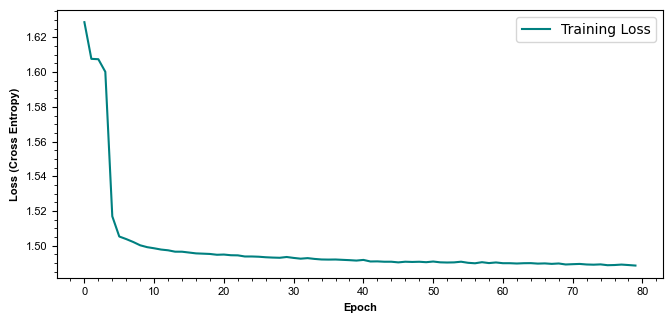

In [12]:
trainer.plotLosses( trainLosses,None )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[WARNING]......... The size of the sliding window has not been specified. By default, it has been set on 5.
c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[WARNING]......... The block weight for the ANNOTATED_5832 well was not provided. Therefore, it has been inferred. Its value is: 14.5
[INFO]......... Block weight for ANNOTATED_5832.csv has been set on: 14.5 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have

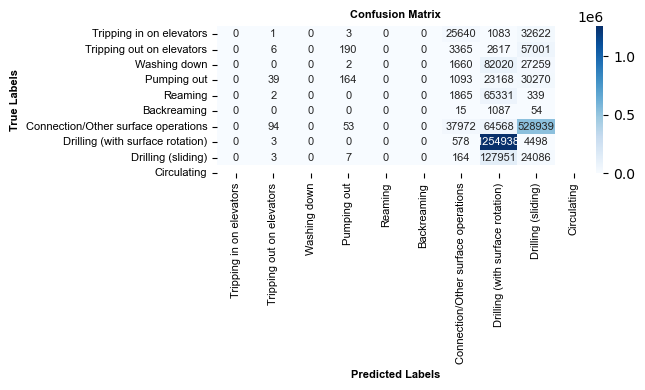

In [13]:
trainer=Trainer(  )
trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp2",
                  pathScaler="scaler_transformer.pkl",modelType='transformer',loadFromPath="transformer_1_chk"
                    )

## Testing on unseen datasets

c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... The current block weight is: 190.0 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.
[INFO]......... Working on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Accuracy: 0.6190
[DEBUG]......... Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG]......... Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG]......... findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG]......... findfont: score(FontEntry(fna

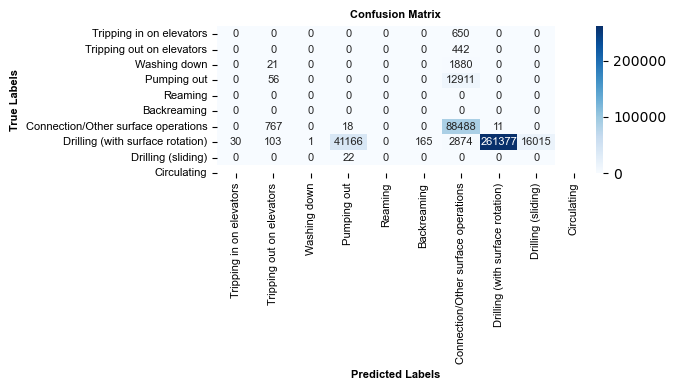

In [7]:
trainer = Trainer(  )
trainer.testModel( pathTest=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp",
                  blockWeights={ "ANNOTATED_va9":190.0 },
                  batchSize=1024,loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\20241103_0600_UF16A7832_checkpoint",
                  modelType='transformer',model=None )